In [8]:
import numpy as np
import torch
from torch import nn
from torch.optim import Adam
from sklearn.base import BaseEstimator, ClassifierMixin
import matplotlib.pyplot as plt

In [9]:
import torch
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
import torch.nn as nn

class OptimizedDifferentiablePchip(nn.Module):
    def __init__(self, x, y):
        super().__init__()
        self.x = x
        self.y = nn.Parameter(y)
        self.n = len(x) - 1
        self.d = None  # To store precomputed derivatives

    def _compute_derivatives(self, y):
        dy = y[1:] - y[:-1]
        dx = self.x[1:] - self.x[:-1]
        slopes = dy / dx
        d = torch.zeros_like(y)
        for i in range(1, len(y) - 1):
            if slopes[i - 1] * slopes[i] > 0:
                w1 = 2 * dx[i] + dx[i - 1]
                w2 = dx[i] + 2 * dx[i - 1]
                d[i] = (w1 + w2) / (w1 / slopes[i - 1] + w2 / slopes[i])
        d[0] = slopes[0]
        d[-1] = slopes[-1]
        return d

    def update_derivatives(self):
        """Compute and store derivatives for the current y values."""
        self.d = self._compute_derivatives(self.y)

    def forward(self, t):
        if self.d is None:
            self.update_derivatives()  # Fallback in case not precomputed
        t = t.contiguous()
        idx = torch.clamp(torch.searchsorted(self.x, t) - 1, 0, self.n - 1)
        x0 = self.x[idx]
        x1 = self.x[idx + 1]
        y0 = self.y[idx]
        y1 = self.y[idx + 1]
        t_norm = (t - x0) / (x1 - x0)
        d0 = self.d[idx]
        d1 = self.d[idx + 1]
        t2 = t_norm * t_norm
        t3 = t2 * t_norm
        h00 = 2 * t3 - 3 * t2 + 1
        h10 = t3 - 2 * t2 + t_norm
        h01 = -2 * t3 + 3 * t2
        h11 = t3 - t2
        dx_segment = x1 - x0
        return h00 * y0 + h10 * dx_segment * d0 + h01 * y1 + h11 * dx_segment * d1

class OptimizedPyTorchGradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, device=None, track_history=False, optimizer_type='adam',
                 scheduler_type='reduce_on_plateau'):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.track_history = track_history
        self.optimizer_type = optimizer_type
        self.scheduler_type = scheduler_type
        torch.manual_seed(random_state)
        np.random.seed(random_state)

    def _to_tensor(self, data, dtype=torch.float32):
        if isinstance(data, torch.Tensor):
            return data.to(self.device, dtype=dtype, non_blocking=True)
        return torch.tensor(data, dtype=dtype, device=self.device)

    def _calculate_class_means(self, X, y):
        mask_1 = y == 1
        self.m1 = torch.mean(X[mask_1], dim=0)
        self.m0 = torch.mean(X[~mask_1], dim=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1
        self.spline_models = nn.ModuleList()
        for i in range(n_features):
            x_min, x_max = X[:, i].min().item(), X[:, i].max().item()
            control_x = torch.linspace(x_min, x_max, self.n_control_points, device=self.device)
            y_min, y_max = X[:, -1].min().item(), X[:, -1].max().item()
            y_mid = (self.m0[-1] + self.m1[-1]) / 2
            y_range = y_max - y_min
            control_y = torch.empty(self.n_control_points, device=self.device).uniform_(
                y_mid - y_range * 0.05, y_mid + y_range * 0.05
            )
            spline = OptimizedDifferentiablePchip(control_x, control_y).to(self.device)
            self.spline_models.append(spline)
        self.initial_control_points = [(m.x.clone(), m.y.clone()) for m in self.spline_models]

    def _calculate_displacement(self, X):
        total_spline = sum(spline(X[:, i]) for i, spline in enumerate(self.spline_models))
        return X[:, -1] - total_spline

    def _update_pseudo_labels(self, X, y):
        m1_displacement = self._calculate_displacement(self.m1.unsqueeze(0))[0]
        self.class_1_pseudo = 1 if m1_displacement > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        return torch.where(y == 1, self.class_1_pseudo, self.class_0_pseudo)

    def _create_optimizer_and_scheduler(self):
        params = [p for spline in self.spline_models for p in spline.parameters()]
        if self.optimizer_type.lower() == 'adam':
            optimizer = torch.optim.Adam(params, lr=self.initial_learning_rate)
        else:
            optimizer = torch.optim.SGD(params, lr=self.initial_learning_rate)
        if self.scheduler_type.lower() == 'reduce_on_plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
                optimizer, mode='min', factor=self.decay_factor,
                patience=self.patience, min_lr=self.min_learning_rate)
        else:
            scheduler = torch.optim.lr_scheduler.StepLR(
                optimizer, step_size=self.patience, gamma=self.decay_factor
            )
        return optimizer, scheduler

    def fit(self, X, y):
        try:
            l = np.unique(y)
            if len(l) != 2:
                raise ValueError("Algorithm for binary classification only.")
            if X.shape[1] < 2:
                raise ValueError("At least 2 features required")

            self.label_mapping = {l[0]: 0, l[1]: 1}
            y = np.where(y == l[0], 0, 1)

            X_tensor = self._to_tensor(X)
            y_tensor = self._to_tensor(y, dtype=torch.long)

            with torch.no_grad():
                self._calculate_class_means(X_tensor, y_tensor)
                self._initialize_control_points(X_tensor)

            optimizer, scheduler = self._create_optimizer_and_scheduler()

            best_error = float('inf')
            best_control_ys = [spline.y.clone() for spline in self.spline_models]
            best_class_1_pseudo = None

            if self.track_history:
                self.error_history_ = []
                self.control_point_history = [self.initial_control_points]

            for epoch in range(self.epochs):
                # Update derivatives for all PCHIP splines
                for spline in self.spline_models:
                    spline.update_derivatives()

                # Compute total spline evaluations once per epoch
                total_spline = sum(spline(X_tensor[:, i]) for i, spline in enumerate(self.spline_models))
                displacements = X_tensor[:, -1] - total_spline

                # Update pseudo labels and compute errors
                pseudo_labels = self._update_pseudo_labels(X_tensor, y_tensor)
                errors = displacements * pseudo_labels <= 0
                error_count = errors.sum().item()

                if self.verbose and epoch % 5 == 0:
                    current_lr = optimizer.param_groups[0]['lr']
                    print(f"Epoch {epoch}: Errors = {error_count}, LR = {current_lr:.6f}")

                if error_count < best_error:
                    best_error = error_count
                    best_control_ys = [spline.y.clone() for spline in self.spline_models]
                    best_class_1_pseudo = self.class_1_pseudo
                    self.best_epoch = epoch
                    if error_count == 0 and epoch > 10:
                        if self.verbose:
                            print(f"Perfect separation achieved at epoch {epoch}")
                        break

                if self.track_history:
                    self.error_history_.append(error_count)
                    self.control_point_history.append(
                        [(s.x.clone().cpu().numpy(), s.y.clone().detach().cpu().numpy())
                         for s in self.spline_models]
                    )

                if error_count == 0:
                    continue

                # Compute loss using precomputed displacements
                error_indices = torch.where(errors)[0]
                displacements_err = displacements[error_indices]
                y_err = y_tensor[error_indices]
                ti = torch.where(y_err == 1, 1, -1)
                loss = torch.mean(torch.relu(1.0 - ti * self.class_1_pseudo * displacements_err))

                if self.lambda_reg > 0:
                    smoothness_penalty = 0
                    for spline in self.spline_models:
                        y_diff = spline.y[1:] - spline.y[:-1]
                        x_diff = spline.x[1:] - spline.x[:-1]
                        smoothness_penalty += torch.mean((y_diff / (x_diff + 1e-8))**2)
                    loss += self.lambda_reg * smoothness_penalty

                optimizer.zero_grad(set_to_none=True)
                loss.backward()
                optimizer.step()

                if scheduler is not None:  # Fixed scheduler check
                    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                        scheduler.step(error_count)
                    else:
                        scheduler.step()
                    if optimizer.param_groups[0]['lr'] <= self.min_learning_rate:
                        if self.verbose:
                            print(f"Minimum learning rate reached at epoch {epoch}")
                        break

            for spline, best_y in zip(self.spline_models, best_control_ys):
                spline.y.data = best_y
            self.class_1_pseudo = best_class_1_pseudo
        except Exception as e:
            print(f"Error in SMPA fit: {str(e)}", flush=True)
            import traceback
            traceback.print_exc(flush=True)
            raise
        return self

    def predict(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        predictions = torch.where(displacements > 0,
                                  torch.tensor(1 if self.class_1_pseudo > 0 else 0, device=self.device),
                                  torch.tensor(0 if self.class_1_pseudo > 0 else 1, device=self.device))
        pred_numpy = predictions.cpu().numpy()
        reverse_mapping = {v: k for k, v in self.label_mapping.items()}
        return np.array([reverse_mapping[p] for p in pred_numpy])

    def predict_proba(self, X):
        X_tensor = self._to_tensor(X)
        displacements = self._calculate_displacement(X_tensor)
        raw_probs = 1 / (1 + torch.exp(-displacements * 0.5))  # Sigmoid, no pseudo-label scaling here

        # Map probabilities to original labels using label_mapping
        probs = torch.zeros(X.shape[0], 2, device=self.device)  # [n_samples, 2] for classes 0 and 1
        if self.class_1_pseudo > 0:
            # Positive displacement means class 1, so raw_probs is P(class 1)
            probs[:, 1] = raw_probs  # P(class 1)
            probs[:, 0] = 1 - raw_probs  # P(class 0)
        else:
            # Negative displacement means class 1, so raw_probs is P(class 0)
            probs[:, 0] = raw_probs  # P(class 0)
            probs[:, 1] = 1 - raw_probs  # P(class 1)

        # Ensure output aligns with original labels via label_mapping
        label_0 = list(self.label_mapping.keys())[list(self.label_mapping.values()).index(0)]
        label_1 = list(self.label_mapping.keys())[list(self.label_mapping.values()).index(1)]
        return probs.cpu().numpy()  # [n_samples, 2], columns: P(label_0), P(label_1)

In [10]:
import torch
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import time

In [11]:


# Load MNIST
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract NumPy arrays
X_train = train_dataset.data.numpy()  # Shape: (60000, 28, 28)
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy()    # Shape: (10000, 28, 28)
y_test = test_dataset.targets.numpy()

# Filter for binary classes (e.g., 0 vs 1)
train_mask = (y_train == 8) | (y_train == 9)
test_mask = (y_test == 8) | (y_test == 9)
X_train_bin = X_train[train_mask].reshape(-1, 28*28)
y_train_bin_orig = y_train[train_mask]
X_test_bin = X_test[test_mask].reshape(-1, 28*28)
y_test_bin_orig = y_test[test_mask]

# Shuffle training data
rng = np.random.RandomState(12)  # For reproducibility
shuffle_idx = rng.permutation(len(X_train_bin))
X_train_bin = X_train_bin[shuffle_idx]
y_train_bin_orig = y_train_bin_orig[shuffle_idx]  # Shuffle the original labels

# Remap: 5 -> 0, 6 -> 1
y_train_bin = np.where(y_train_bin_orig == 8, 0, 1)
y_test_bin = np.where(y_test_bin_orig == 8, 0, 1)

# Initialize your SMPA model
smpa_model = OptimizedPyTorchGradientSMPA(
    learning_rate=0.05,
    epochs=200,
    random_state=4,
    verbose=True,
    n_control_points=12,
    track_history=True
)

In [12]:
from sklearn.preprocessing import StandardScaler

In [13]:
def reorder_least_correlated_feature(X, standardize=True, feature_order=None, scaler=None, valid_mask=None):
    X_np = np.asarray(X)
    if valid_mask is None:  # Train: compute mask
        variances = np.var(X_np, axis=0)
        valid_mask = variances > 0
        print(f"Train: Filtered {np.sum(~valid_mask)} zero-variance features")
    X_np = X_np[:, valid_mask]  # Apply mask to both train and test

    if feature_order is None:  # Train
        if standardize:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_np)
        else:
            X_scaled = X_np.copy()
        corr_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
        n_features = X_scaled.shape[1]
        avg_corr = (np.sum(corr_matrix, axis=1) - np.diag(corr_matrix)) / (n_features - 1)
        target_idx = np.argmin(avg_corr)
        feature_order = list(range(n_features))
        feature_order.pop(target_idx)
        feature_order.append(target_idx)
        X_reordered = X_scaled[:, feature_order]
    else:  # Test
        if standardize and scaler is not None:
            X_scaled = scaler.transform(X_np)  # Now same # of features
            X_reordered = X_scaled[:, feature_order]
        else:
            X_reordered = X_np[:, feature_order]
    return X_reordered, feature_order, scaler, valid_mask

# Apply with consistent mask
X_train_reordered, feature_order, scaler, valid_mask = reorder_least_correlated_feature(X_train_bin, standardize=True)
X_test_reordered, _, _, _ = reorder_least_correlated_feature(X_test_bin, standardize=True, feature_order=feature_order, scaler=scaler, valid_mask=valid_mask)

Train: Filtered 183 zero-variance features


In [14]:
# Benchmark training time
start_time = time.time()
smpa_model.fit(X_train_reordered, y_train_bin_orig)
train_time = time.time() - start_time
print(f"Training time: {train_time:.2f} seconds")

Epoch 0: Errors = 7363, LR = 0.050000
Epoch 5: Errors = 6172, LR = 0.050000
Epoch 10: Errors = 4323, LR = 0.050000
Epoch 15: Errors = 2551, LR = 0.050000
Epoch 20: Errors = 1546, LR = 0.050000
Epoch 25: Errors = 1033, LR = 0.050000
Epoch 30: Errors = 714, LR = 0.050000
Epoch 35: Errors = 541, LR = 0.050000
Epoch 40: Errors = 422, LR = 0.050000
Epoch 45: Errors = 323, LR = 0.050000
Epoch 50: Errors = 244, LR = 0.050000
Epoch 55: Errors = 186, LR = 0.050000
Epoch 60: Errors = 110, LR = 0.050000
Epoch 65: Errors = 11696, LR = 0.050000
Epoch 70: Errors = 11012, LR = 0.050000
Epoch 75: Errors = 10853, LR = 0.045000
Epoch 80: Errors = 10624, LR = 0.045000
Epoch 85: Errors = 8790, LR = 0.040500
Epoch 90: Errors = 6353, LR = 0.040500
Epoch 95: Errors = 4205, LR = 0.040500
Epoch 100: Errors = 2892, LR = 0.036450
Epoch 105: Errors = 2109, LR = 0.036450
Epoch 110: Errors = 1625, LR = 0.032805
Epoch 115: Errors = 1302, LR = 0.032805
Epoch 120: Errors = 1081, LR = 0.029525
Epoch 125: Errors = 919, 

In [15]:
# Predict and benchmark inference time
start_time = time.time()
y_pred = smpa_model.predict(X_test_reordered)
predict_time = time.time() - start_time
print(f"Prediction time: {predict_time:.2f} seconds")

y_train_pred = smpa_model.predict(X_train_reordered)
train_accuracy = accuracy_score(y_train_bin_orig, y_train_pred)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate
accuracy = accuracy_score(y_test_bin_orig, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")
print(classification_report(y_test_bin_orig, y_pred))

Prediction time: 0.13 seconds
Training Accuracy: 0.9907
Test Accuracy: 0.9617
              precision    recall  f1-score   support

           8       0.96      0.96      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.96      1983
   macro avg       0.96      0.96      0.96      1983
weighted avg       0.96      0.96      0.96      1983



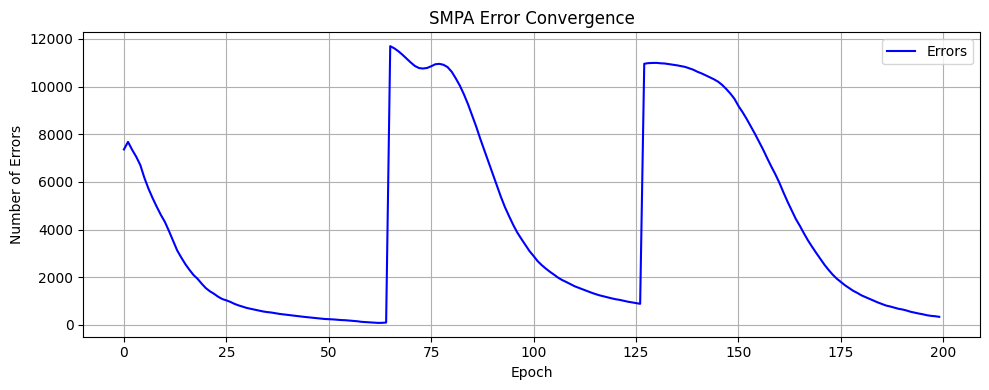

In [16]:
import matplotlib.pyplot as plt

def plot_smpa_convergence(model, figsize=(10, 4), title="SMPA Error Convergence"):
    if not hasattr(model, 'track_history') or not model.track_history or not hasattr(model, 'error_history_'):
        print("Error: Model must have track_history=True and be fitted with error_history_ recorded.")
        return None

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(model.error_history_, 'b-', label='Errors')
    ax.set_title(title)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Number of Errors')
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    return fig

fig = plot_smpa_convergence(smpa_model)
plt.show()

In [17]:
from sklearn.svm import SVC

svm = SVC(C = 1.0, kernel='rbf')

svm.fit(X_train_reordered, y_train_bin_orig)
print(svm.score(X_train_reordered, y_train_bin_orig))

print(svm.score(X_test_reordered, y_test_bin_orig))

0.9978813559322034
0.9838628340897629


In [18]:
import itertools
from sklearn.preprocessing import StandardScaler

In [19]:
class OvOSMPAWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6, smoothing_factor=0.0001, spline_type='cubic',
                 device=None, track_history=False, optimizer_type='adam', scheduler_type='reduce_on_plateau'):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.smoothing_factor = smoothing_factor
        self.spline_type = spline_type
        self.device = device if device is not None else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.track_history = track_history
        self.optimizer_type = optimizer_type
        self.scheduler_type = scheduler_type

    def fit(self, X, y):
        class_labels = np.unique(y)
        class_combos = itertools.combinations(class_labels, r=2)
        self.classifiers = {}
        n_classes = len(class_labels)
        total_combos = n_classes * (n_classes - 1) // 2
        counter = 1

        for pair in class_combos:
            print(f"Training {counter:02d}/{total_combos:02d} classifier: {pair[0]} vs {pair[1]}")
            counter += 1
            mask = np.isin(y, [pair[0], pair[1]])
            X_pair = X[mask]
            y_pair = y[mask]

            # Binarize y_pair to 0 and 1
            y_pair_binary = np.where(y_pair == pair[0], 0, 1)

            # Check and filter zero-variance features
            variances = np.var(X_pair, axis=0)
            zero_variance_count = np.sum(variances == 0)
            print(f"  Pair {pair}: Zero-variance features: {zero_variance_count}")
            if zero_variance_count > 0:
                print(f"    Zero-variance indices: {np.where(variances == 0)[0]}")

            valid_features = variances > 0
            X_pair_filtered = X_pair[:, valid_features]
            print(f"  X_pair_filtered shape: {X_pair_filtered.shape}")

            unique_labels = np.unique(y_pair_binary)
            if len(unique_labels) != 2:
                print(f"Warning: Expected 2 classes but found {len(unique_labels)} for pair {pair}")
                continue

            print(f"  Class distribution: {pair[0]}: {np.sum(y_pair_binary == 0)}, {pair[1]}: {np.sum(y_pair_binary == 1)}")

            smpa = OptimizedPyTorchGradientSMPA(
                learning_rate=self.learning_rate,
                epochs=self.epochs,
                random_state=self.random_state,
                verbose=self.verbose,
                lambda_reg=self.lambda_reg,
                patience=self.patience,
                decay_factor=self.decay_factor,
                min_learning_rate=self.min_learning_rate,
                n_control_points=self.n_control_points,
                device=self.device,
                track_history=self.track_history,
                optimizer_type=self.optimizer_type,
                scheduler_type=self.scheduler_type
            )

            try:
                smpa.fit(X_pair_filtered, y_pair_binary)
                self.classifiers[pair] = (smpa, valid_features)
            except Exception as e:
                print(f"  Error training {pair}: {str(e)}")
                continue

        if not self.classifiers:
            raise ValueError("No classifiers trained!")

        self.class_labels_ = class_labels
        return self

    def predict(self, X):
        # Initialize probability scores for each class
        prob_scores = np.zeros((X.shape[0], len(self.class_labels_)))
        label_to_idx = {label: idx for idx, label in enumerate(self.class_labels_)}

        # Sum probabilities from each pairwise classifier
        for pair, clf_info in self.classifiers.items():
            model = clf_info['model']
            features = clf_info['features']
            X_filtered = X[:, features]
            probs = model.predict_proba(X_filtered)  # [n_samples, 2] for pair’s classes

            # Map pair’s labels to class_labels_ indices
            label_0 = list(model.label_mapping.keys())[list(model.label_mapping.values()).index(0)]
            label_1 = list(model.label_mapping.keys())[list(model.label_mapping.values()).index(1)]
            idx_0 = label_to_idx[label_0]
            idx_1 = label_to_idx[label_1]

            # Add probabilities to corresponding class scores
            prob_scores[:, idx_0] += probs[:, 0]  # P(label_0)
            prob_scores[:, idx_1] += probs[:, 1]  # P(label_1)

        # Predict class with highest total probability
        return self.class_labels_[np.argmax(prob_scores, axis=1)]

In [20]:
y = [0, 1, 1, 0, 2, 0]
a = np.unique(y)
print(a)
combos = itertools.combinations(a, r = 2)
for i in combos:
  print(i)
  print(i[0], i[1])

if len(a) != 2:
  print("tested")

[0 1 2]
(0, 1)
0 1
(0, 2)
0 2
(1, 2)
1 2
tested


In [21]:
transform = transforms.ToTensor()
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Extract NumPy arrays
# Extract and reshape NumPy arrays
X_train = train_dataset.data.numpy().reshape(60000, -1)  # Shape: (60000, 784)
y_train = train_dataset.targets.numpy()
X_test = test_dataset.data.numpy().reshape(10000, -1)    # Shape: (10000, 784)
y_test = test_dataset.targets.numpy()

# Shuffle training data
rng = np.random.RandomState(12)  # For reproducibility
shuffle_idx = rng.permutation(len(X_train))
X_train = X_train[shuffle_idx]
y_train = y_train[shuffle_idx]  # Shuffle the original labels

In [22]:
X_train.shape

(60000, 784)

In [23]:
def reorder_least_correlated_feature(X, standardize=True, feature_order=None, scaler=None, valid_mask=None):
    X_np = np.asarray(X)
    if valid_mask is None:  # Train: compute mask
        variances = np.var(X_np, axis=0)
        valid_mask = variances > 0
        print(f"Train: Filtered {np.sum(~valid_mask)} zero-variance features")
    X_np = X_np[:, valid_mask]  # Apply mask to both train and test

    if feature_order is None:  # Train
        if standardize:
            scaler = StandardScaler()
            X_scaled = scaler.fit_transform(X_np)
        else:
            X_scaled = X_np.copy()
        corr_matrix = np.abs(np.corrcoef(X_scaled, rowvar=False))
        n_features = X_scaled.shape[1]
        avg_corr = (np.sum(corr_matrix, axis=1) - np.diag(corr_matrix)) / (n_features - 1)
        target_idx = np.argmin(avg_corr)
        feature_order = list(range(n_features))
        feature_order.pop(target_idx)
        feature_order.append(target_idx)
        X_reordered = X_scaled[:, feature_order]
    else:  # Test
        if standardize and scaler is not None:
            X_scaled = scaler.transform(X_np)  # Now same # of features
            X_reordered = X_scaled[:, feature_order]
        else:
            X_reordered = X_np[:, feature_order]
    return X_reordered, feature_order, scaler, valid_mask

# Apply with consistent mask
#X_train_reordered, feature_order, scaler, valid_mask = reorder_least_correlated_feature(X_train_bin, standardize=True)
#X_test_reordered, _, _, _ = reorder_least_correlated_feature(X_test_bin, standardize=True, feature_order=feature_order, scaler=scaler, valid_mask=valid_mask)

In [24]:
OvA_SMPA = OvOSMPAWrapper(
  learning_rate=0.08,
  epochs=200,
  random_state=12,
  verbose=True,
  n_control_points=10,
  optimizer_type='adam',
  track_history=True
  )

start_time = time.time()
OvA_SMPA.fit(X_train, y_train)
train_time = time.time() - start_time

pred_time_start = time.time()
y_pred = OvA_SMPA.predict(X_test)
predict_time = time.time() - pred_time_start

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

Training 01/45 classifier: 0 vs 1
  Pair (0, 1): Zero-variance features: 167
    Zero-variance indices: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  46  47  48  49  50  51  52  53  54  55  56  57  58  61  65
  77  78  79  80  81  82  83  84  85 110 111 112 113 138 139 140 141 167
 168 169 196 197 225 250 251 252 279 280 308 336 391 392 393 419 420 421
 447 448 476 560 644 645 646 671 672 673 674 699 700 701 702 703 704 719
 720 721 722 723 724 725 726 727 728 729 730 731 732 733 734 735 736 737
 740 741 745 746 747 748 749 750 751 752 753 754 755 756 757 758 759 760
 761 762 763 764 765 766 767 768 769 770 771 772 773 774 775 776 777 778
 779 780 781 782 783]
  X_pair_filtered shape: (12665, 617)
  Class distribution: 0: 5923, 1: 6742
Epoch 0: Errors = 9971, LR = 0.080000
Epoch 5: Errors = 1098, LR = 0.080000
Epoch 10: Errors = 97, LR = 0.080000
Epoch 15: Errors = 25, LR =

TypeError: tuple indices must be integers or slices, not str

In [ ]:
pred_time_start = time.time()
y_pred = OvA_SMPA.predict(X_test)
predict_time = time.time() - pred_time_start

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

In [ ]:
print(predict_time)